In [4]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from pandas.io.json import json_normalize
from sklearn.metrics import make_scorer
from sklearn import linear_model
from collections import Counter
from textblob import TextBlob
from sklearn import metrics
from scipy import ndimage
from scipy import stats
from time import time
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import textblob
import datetime
import operator
import scipy
import json
import nltk
import time
import h5py
import ast
import re

df = pd.read_csv('./ted_main.csv')
df3 = pd.read_csv('./transcripts.csv')
df4 = df
df.head()



,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


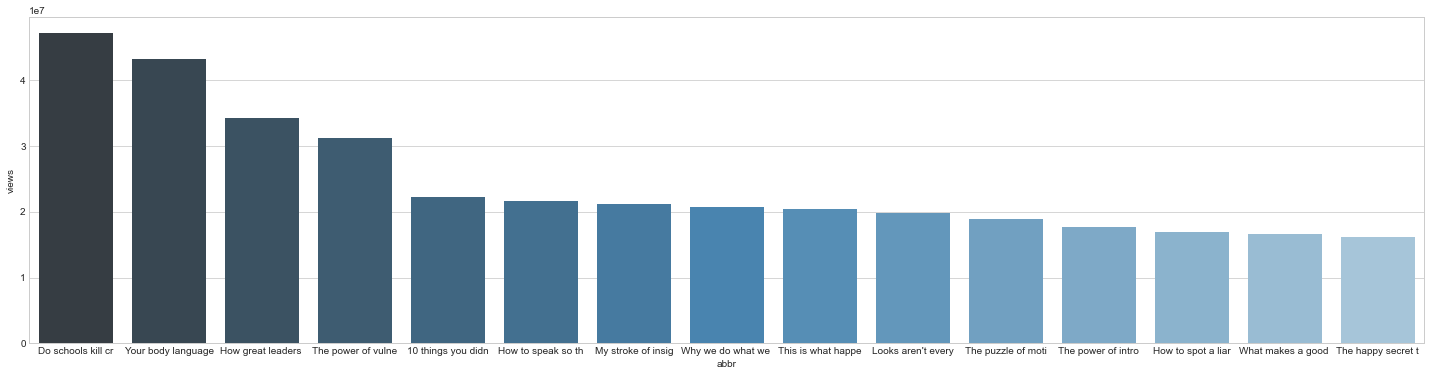

In [5]:
# Most popular TED Talk
pop_talks = df[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False)[:15]
pop_talks['abbr'] = pop_talks['title'].apply(lambda x: x[:18]) 
sns.set_style("whitegrid")
plt.figure(figsize=(25,6))
sns.barplot(x='abbr', y='views', data=pop_talks, palette="Blues_d")





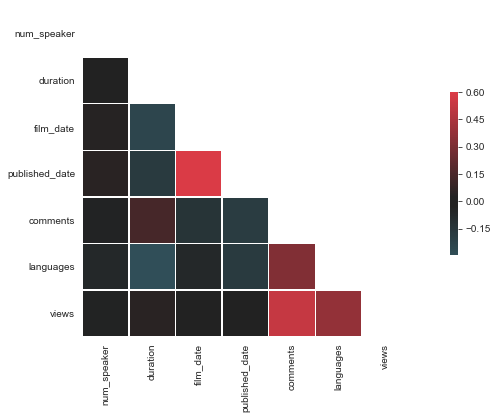

In [111]:
# Most influencing factors contributing in any video
corr = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']].corr() 
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(15, 6)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True, center="dark") 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [112]:
# How TED talks are related
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'
theme_df = df.drop('tags', axis=1).join(s)
len(theme_df['theme'].value_counts())


416

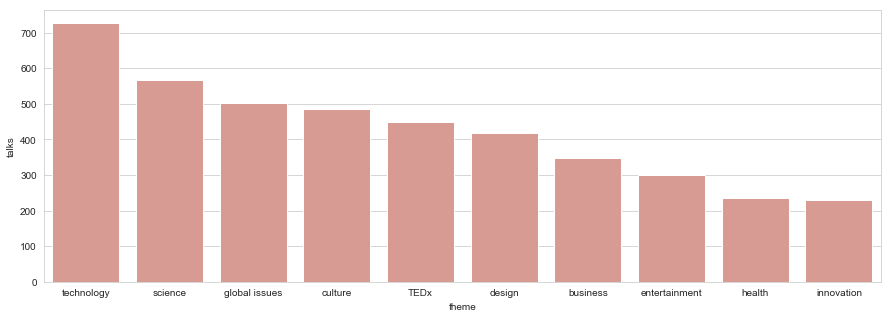

In [113]:
# Most popular genres
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
plt.figure(figsize=(15,5))
sns.barplot(x='theme', y='talks', data=pop_themes.head(10), color="salmon", saturation=.5)
plt.show()


In [114]:
#Do people comment on every TED Talk?
df['comments'].describe()

count    2550.000000
mean      191.562353
std       282.315223
min         2.000000
25%        63.000000
50%       118.000000
75%       221.750000
max      6404.000000
Name: comments, dtype: float64

In [115]:
#Date Convertion
df = df4
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = pd.to_datetime(df['published_date'])
df['film_date'] = pd.to_datetime(df['film_date'])
temp = datetime.date(2018,1,1)
temp = pd.to_datetime(temp)
df['published_date'] = temp - df['published_date']
df['film_date'] = temp - df['film_date']
df['published_date'] = df['published_date'].dt.days
df['film_date'] = df['film_date'].dt.days



In [116]:
# Top 35 Tags extraction
df2 = df['tags']
temp = {}
for each in df2.values:
    for every in each:
        test = re.sub('[^A-Za-z0-9]+', ' ', every)
        data = test.split()

        for entry in data:
            entry = entry.lower()

            if entry in temp.keys():
                temp[entry] += 1 
            else:
                temp[entry]= 1

new = pd.DataFrame.from_dict(temp, orient="index")

print(new.sort_values(by = 0, ascending=False).head(15))
topTags = new.sort_values(by = 0, ascending=False).head(35).index
newtopTags = []
for i in topTags: newtopTags.append(i.strip())
xx = pd.DataFrame(0, index=np.arange(len(df)), columns=newtopTags)
for i in range(len(df)): 
    for j in topTags:
        j = str(j).strip()
    if str(j) in str(df['tags'][i]).lower():
        xx[str(j)][i] = 1
frames = [df, xx]
result = pd.concat(frames, axis=1)

print(result.shape)

                 0
technology     727
science        675
global         565
design         526
issues         501
health         489
culture        486
tedx           450
business       374
change         305
entertainment  299
art            289
social         270
ted            265
biology        234
(2550, 52)


In [117]:
#Sentiment Polarity Extraction - NLP
polarity = []
subj = []
for t in df3['transcript']:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)
df3['polarity'] = polarity
df3['subjectivity'] = subj
result = result.merge(df3,on = 'url', how='inner')

print(result.shape)

(2467, 55)


In [118]:
# extraction of ratings
result['ratings'] = result['ratings'].apply(lambda x: eval(str(x)))
json_data = result['ratings']
newRatings = ['Funny','Beautiful','Ingenious','Courageous','Longwinded','Confusing','Informative','Fascinating','Unconvincing','Persuasive','Jaw-dropping','OK', 'Obnoxious','Inspiring']
yy = pd.DataFrame(0, index=np.arange(len(result)), columns=newRatings)
ind = 0
for i in json_data:
    for j in i:
        temp = j['name']
        yy[temp][ind] = j['count']
    ind +=1
frame1 = [result, yy]
result = pd.concat(frame1, axis=1) 

print(result.shape)

 

(2467, 69)


In [11]:
# Description & Title Subjectivity Feature Extraction
tem1 = []
tem2 = []
tem3 = result['description'] #print(type(tem3))
for i in tem3:
    tem = TextBlob(i)
    tem1.append(tem.sentiment.subjectivity)
    tem2.append(tem.sentiment.polarity)
result['des_subj'] = tem1
result['des_sent'] = tem2
result.columns
print(result.shape)
tem1 = []
tem2 = []
tem3 = result['title'] #print(type(tem3))
for i in tem3:
    tem = TextBlob(i)
    tem1.append(tem.sentiment.subjectivity)
    tem2.append(tem.sentiment.polarity)
result['tit_subj'] = tem1
result['tit_sent'] = tem2
result.columns

print(result.shape)

(2467, 71)
(2467, 73)


In [12]:
# Speaker Occupcation Feature Extraction
li = result['speaker_occupation'] 
lli=[]
lis = []
for i in li:
    if type(i) == str:
        k = i.lower().replace('/',',').replace(';',',').split(',') 
        lis.append(k)
        for j in k:
            lli.append(j.strip().lower())
    else: 
        lis.append([])
        pass
lid = Counter(lli)

authdf = pd.DataFrame.from_dict(lid, orient="index").sort_values(by=0, ascending =False).head(10).index
newauth = pd.DataFrame(0, index=np.arange(len(result)), columns=authdf)
for i in range(len(result)):
    for j in authdf:
        if str(j) in lis[i]:
            newauth[str(j)][i] = 1
frames3 = [result, newauth]
result = pd.concat(frames3, axis=1)

print(result.shape)
 

(2467, 83)


In [13]:
xyz = result.describe().reset_index()
print(xyz.columns)

Index(['index', 'comments', 'duration', 'film_date', 'languages',
       'num_speaker', 'published_date', 'views', 'technology', 'science',
       'global', 'design', 'issues', 'health', 'culture', 'tedx', 'business',
       'change', 'entertainment', 'art', 'social', 'ted', 'biology',
       'innovation', 'society', 'music', 'brain', 'future', 'communication',
       'creativity', 'economics', 'humanity', 'collaboration', 'environment',
       'medicine', 'activism', 'education', 'community', 'history', 'women',
       'children', 'fellows', 'invention', 'polarity', 'subjectivity', 'Funny',
       'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
       'Informative', 'Fascinating', 'Unconvincing', 'Persuasive',
       'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'des_subj', 'des_sent',
       'tit_subj', 'tit_sent', 'writer', 'author', 'designer', 'artist',
       'entrepreneur', 'inventor', 'activist', 'journalist', 'educator',
       'psychologist'],
      dtype

In [14]:
######## Histogram Plot ###################

      comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
5          672  Tony Robbins discusses the "invisible forces" ...      1305   
6          919  When two young Mormon missionaries knock on Ju...       992   
7           46  Architect Joshua Prince-Ramus takes the audien...      1198   
8          852  Philosopher Dan Dennett calls for religion -- ...      1485   
9          900  Pastor Rick Warren, author of "The Purpose-Dri...      1262   
10          79  Accepting his 2006 TED Prize, Cameron Sinclair...      1414   
11          55  Jehane Noujaim unveils her 2006 TED 

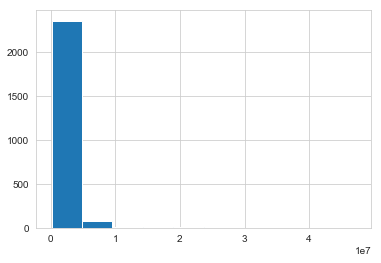

In [97]:
plt.hist((result['views']))
print(result)

(array([ 26., 180., 532., 959., 475., 185.,  64.,  28.,  14.,   4.]),
 array([5.19283219, 5.4409681 , 5.68910402, 5.93723994, 6.18537586,
        6.43351178, 6.6816477 , 6.92978362, 7.17791953, 7.42605545,
        7.67419137]),
 <a list of 10 Patch objects>)

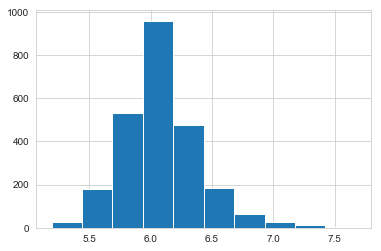

In [16]:
plt.hist(np.log10(result['views']))

In [17]:
X_temp = result[['comments', 'duration', 'film_date', 'languages',
       'num_speaker', 'published_date', 'views', 'technology', 'science',
       'global', 'design', 'issues', 'health', 'culture', 'tedx', 'business',
       'change', 'entertainment', 'art', 'social', 'ted', 'biology',
       'innovation', 'society', 'music', 'brain', 'future', 'communication',
       'creativity', 'economics', 'humanity', 'collaboration', 'environment',
       'medicine', 'activism', 'education', 'community', 'history', 'women',
       'children', 'fellows', 'invention', 'polarity', 'subjectivity', 'Funny',
       'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
       'Informative', 'Fascinating', 'Unconvincing', 'Persuasive',
       'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'des_subj', 'des_sent',
       'tit_subj', 'tit_sent', 'writer', 'author', 'designer', 'artist',
       'entrepreneur', 'inventor', 'activist', 'journalist', 'educator',
       'psychologist']]
y = np.log10(result['views'])

mu = X_temp.mean(axis=0) 
stdv = X_temp.std(axis = 0) 
X = (X_temp - mu)/stdv 


In [18]:
########################################################

In [19]:
# Regression Result on Training Set:

In [20]:
########################################################

In [21]:

print("Training Data Summary")
print("=======================")
X_train, X_test, y_train, y_test = train_test_split(np.nan_to_num(X),y,test_size = 0.3) 
                                   

Lreg = linear_model.LinearRegression(normalize=True)
Lreg.fit(X_train, y_train)
predicted = Lreg.predict(X_train)
temp1 = Lreg.score(X_train,y_train)

print("Linear Regression Score on Training Data: {}% \n".format(temp1*100))

print("Ridge Regression Scores on Training:")
print("====================================")
li = [0,0.1,0.5,5]
regli = []
for i in li:
    Rreg = linear_model.Ridge(normalize = True, alpha = i) 
    Rreg.fit(X_train, y_train)
    regli.append(Rreg)
    predicted1 = Lreg.predict(X_train)
    temp2 = Rreg.score(X_train,y_train)
    print("Score with Alpha {} is {}%".format(i,temp2*100)) 
    #print(temp2*100)

Training Data Summary
Linear Regression Score on Training Data: 74.95804339689137% 

Ridge Regression Scores on Training:
Score with Alpha 0 is 74.9578226424004%
Score with Alpha 0.1 is 73.43359725239539%
Score with Alpha 0.5 is 66.81048280767727%
Score with Alpha 5 is 45.450200709278725%


In [22]:
# Regression Result on Testing Set:
print("Testing Data Summary")
print("====================")
predicted2 = Lreg.predict(X_test)
temp4 = Lreg.score(X_test,y_test)
print("Linear Regression Score on testing Data is {}% \n".format(temp4*100)) #print(metrics.r2_score(predicted1, y_test)*100)
print("Ridge Regression Scores on Testing:") 
print("===================================") 
for j in range(4):
    predicted2 = regli[j].predict(X_test)
    temp3 = regli[j].score(X_test,y_test)
    print("Score with Alpha {} is {}%".format(li[j],temp3*100))

Testing Data Summary
Linear Regression Score on testing Data is 68.21145273156144% 

Ridge Regression Scores on Testing:
Score with Alpha 0 is 68.22751485655006%
Score with Alpha 0.1 is 67.08188135304746%
Score with Alpha 0.5 is 62.15153281156388%
Score with Alpha 5 is 42.772697681281755%


In [23]:
### Writing to csv file for Neural Network
X.to_csv("/Users/msharma/Documents/Stevens/CS513_2ndSem/513_Assignments/Project/new1.csv")
y.to_csv("/Users/msharma/Documents/Stevens/CS513_2ndSem/513_Assignments/Project/new2.csv")
 

In [24]:
########################################################

In [25]:
#####################  Neural Network  ###################

In [26]:
########################################################

In [27]:
# Neural Network algorithm and Training
Xpd = pd.read_table("./new1.csv", index_col=0, sep=',')
ypd = pd.read_table("./new2.csv", index_col=0, sep=',', header=None)
X_el = np.matrix(Xpd)
Y_el = np.matrix(ypd)
X, X_test, Y, y_test = train_test_split(X_el, Y_el, test_size=0.10, random_state =324)
X = X.T
print(Y.shape) #(m,1)
print(X.shape) #(n,m)

(2220, 1)
(72, 2220)


In [28]:
#Hyper Parameter (W, b) Initialization

def initialize_parameters_deep(layers_dims,initialization="he"):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) # number of layers in the network
    for l in range(1, L):
        if initialization == "zeros":
            parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1)) 
        elif initialization == "random":
            parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1)) 
        elif initialization == "he":
            parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1)) 
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l- 1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))

    return parameters

In [29]:
def sigmoid(z):
    s = 1/(1+np.exp(-z)) 
    return s,z

def relu(z):
    s = (abs(z) + z) / 2 
    return s,z

In [30]:
def linear_forward(A, W, b):
    
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0], A.shape[1])) 
    cache = (A, W, b)
    
    return Z, cache

In [31]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache". 
        Z, linear_cache = linear_forward(A_prev,W,b)
        #Z = np.dot(W,A_prev) + b
        A, activation_cache = sigmoid(Z)
        #print("sigmoid")
        
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache". 
        Z, linear_cache = linear_forward(A_prev,W,b)
        #Z = np.dot(W,A_prev) + b
        A, activation_cache = relu(Z)
        #print("relu")
        
    assert (A.shape == (W.shape[0], A_prev.shape[1])) 
    cache = (linear_cache, activation_cache)
    return A, cache

In [32]:
def L_model_forward(X, parameters,keep_prob=1):
    caches = []
    A=X
    L = len(parameters) // 2 # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list. 
    for l in range(1, L):
        A_prev = A
        #print(A_prev.shape)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)] ,parameters['b' + str(l)], "relu")
        D = np.random.rand(A.shape[0],A.shape[1])
        D = D < keep_prob
        A = np.multiply(A,D )
        A = A/keep_prob
        cache = cache + (D,)
        caches.append(cache)
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A,parameters['W' + str(L)] ,parameters['b' + str(L)],"relu" )
    caches.append(cache) 
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [33]:
# Cost Computation
def compute_cost(AL, Y,parameters,lambd,regularized=False):
    m = Y.shape[1]
    cross_entropy_cost = (1/(2*m))* np.sum(np.square(AL - Y))
    loop_len = len(parameters)//2
    if regularized == True: 
        temp = 0
        for i in range(1,loop_len+1):
            temp += np.sum(np.square(parameters['W' + str(i)]))
        L2_regularization_cost = (1/m) * (lambd/2) * temp
        cost = cross_entropy_cost + L2_regularization_cost 
    else:
        cost = cross_entropy_cost
    cost = np.squeeze(cost)
    assert(cost.shape == ()) 
    return cost

In [34]:
#Back Propogation
def linear_backward(dZ, cache,D,lambd,keep_prob,val):
    #linear_cache, activation_cache,D = cache
    linear_cache, activation_cache, dummy= cache
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dA_prev = np.dot(W.T, dZ)
    if val ==0: 
        dZ_prev = None
    else:
        dA_prev = np.multiply(dA_prev,D )
        dA_prev = dA_prev/keep_prob
        dZ_prev = np.multiply(dA_prev, np.int64(A_prev > 0))
    dW = (1./m) * np.dot(dZ,A_prev.T) + ((lambd/m) * W) 
    db = (1./m) * np.sum(dZ,axis=1)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape) 
    return dZ_prev, dA_prev, dW, db

In [35]:
def L_model_backward(AL, Y, caches, lambd,keep_prob):
    grads = {}
    L = len(caches) # the number of layers
    #print(L)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Initializing the backpropagation and dZL for last layer
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    linear_cache, activation_cache = caches[L-1]
    A_prev2, W3, b3 = linear_cache
    dZ_prev3 = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(dZ_prev3, A_prev2.T)+((lambd/m) * W3)
    grads["db" + str(L)] = 1./m * np.sum(dZ_prev3, axis=1)
    dA_prev2 = np.dot(W3.T, dZ_prev3)
    linear_cache, activation_cache,D = caches[L-2]
    dA_prev2 = np.multiply(D,dA_prev2)
    dA_prev2 = dA_prev2/keep_prob
    dZ = np.multiply(dA_prev2, np.int64(A_prev2 > 0))
    x, y,D_prev = caches[L-3]
    # Loop from l=L-2 to l=0
    for l in reversed(range(L)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l-1]
        D = D_prev
        val = l - 1
        dZ_prev, dA_prev_temp, dW_temp, db_temp = linear_backward(dZ, current_cache, D,lambd,keep_prob, val) 
        if val ==0:
            pass 
        else:
            x, y, D_prev = caches[l-2]
        dZ = dZ_prev
        #grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l)] = dW_temp 
        grads["db" + str(l)] = db_temp 
        if val ==0:
            break 
    return grads

In [36]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)] 
    return parameters

In [37]:
#Deep Learning Model

def model(X, Y, learning_rate = 0.3, num_iterations = 5000, print_cost = True, lambd = 0.01, keep_prob = 1):
    grads = {}
    costs = [] # to keep track of the cost 
    m = X.shape[1] # number of examples 
    layers_dims = [X.shape[0],100,50, 1]
    parameters = initialize_parameters_deep(layers_dims,"random")

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        AL, cache = L_model_forward(X, parameters,keep_prob) 
        cost = compute_cost(AL, Y.T,parameters,lambd,True) 
        grads = L_model_backward(AL, Y, cache, lambd,keep_prob)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost)) 
            if (i>= 3000):
                x = str(input("Wanna continue?")) 
                if x == str("No"):
                    break
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters,grads

/Users/msharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Cost after iteration 0: 18.61159086269781
Cost after iteration 1000: 0.0046134425003164
Cost after iteration 2000: 0.003991607709022952
Cost after iteration 3000: 0.0038099009519145088
Wanna continue?No


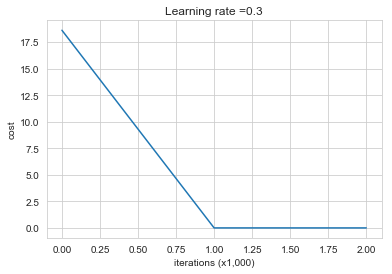

In [38]:
parameters,grads = model(np.nan_to_num(X), Y, lambd=4)

In [39]:
print("On the train set:")
print("=================")
AL, xx = L_model_forward(np.nan_to_num(X), parameters)
te = metrics.r2_score(AL.T, Y)
print("Score: {}%".format(te*100))
print("On the Testing set:") 
print("===================")
Y_predicted, xx = L_model_forward(np.nan_to_num(X_test.T), parameters) 
tem = metrics.r2_score(Y_predicted.T, y_test) 
print("Score: {}%".format(tem*100))

On the train set:
Score: 98.1838091641644%
On the Testing set:
Score: 97.47074117973044%


In [40]:
print(y_test[:5].T)
print(Y_predicted[0,:5])

[[6.30752898 5.84710542 6.0216837  5.71843276 5.88094215]]
[[6.31223385 5.80112615 5.98900114 5.76111091 5.92596997]]


In [41]:
########################################################

In [42]:
# WORD CLOUD

In [43]:
########################################################

In [44]:
corpus = ' '.join(df3['transcript'])
corpus = corpus.replace('.', '. ')

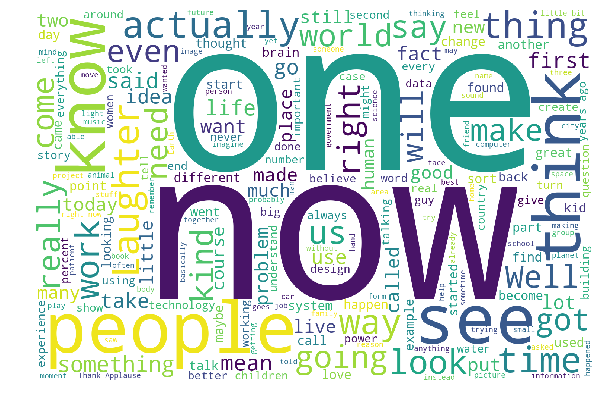

In [45]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(stopwords=STOPWORDS, background_color='white',width=1500,height=1000).generate(corpus)
plt.figure(figsize=(10,12))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [46]:
########################################################

In [47]:
########### RANDOM FOREST !!!##############

In [48]:
########################################################

In [70]:
df = pd.read_csv('./ted_main.csv')
df3 = pd.read_csv('./transcripts.csv')
print (df.shape, df3.shape)

(2550, 17) (2467, 2)


In [71]:
# Step 1 : exclude those that are non-TED events

df = df[df['event'].str[0:3]=='TED'].reset_index()
df.loc[:,'event_cat'] = df['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')

print ("No. of talks remain: ", len(df))

No. of talks remain:  2439


In [73]:
# Step 2 : Construct a decision tree
df['ratings']=df['ratings'].str.replace("'",'"')
df=df.merge(df.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

In [93]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']
df['positive']=df.loc[:,Positive].sum(axis=1)+1
df['negative']=df.loc[:,Negative].sum(axis=1)+1
df['pop_ratio']=df['positive']/df['negative']
df.loc[:,'Popular'] = df['pop_ratio'].apply (lambda x: 1 if x >5 else 0)

print ("Popular talks that are not popular: ", len(df[df['Popular']==0]))

overall_mean_popular = np.mean(df.Popular)
print ("Popular talks Ratio: {:.4f}".format(overall_mean_popular))

lw = df.Longwinded / (df.positive + df.negative)
lw_talks_id = lw[lw>0.2].index
df.loc[lw_talks_id,['title','main_speaker','speaker_occupation','event','duration','Longwinded','positive','negative','Popular']]


Popular talks that are not popular:  301
Popular talks Ratio: 0.8766


,title,main_speaker,speaker_occupation,event,duration,Longwinded,positive,negative,Popular
113,A memorial at Ground Zero,David Rockwell,"Architect, experience designer",TED2002,1477,64,129,144,0
177,"A master architect asks, Now what?",Frank Gehry,Architect,TED2002,1320,161,492,273,0
201,My days as a young rebel,Frank Gehry,Architect,TED1990,2678,76,209,104,0
393,Rethinking the way we sit down,Niels Diffrient,Designer,TED2002,1040,234,466,318,0
396,Comics of bygone New York,Ben Katchor,Cartoonist,TED2002,671,64,128,121,0
725,The path to ending ethnic conflicts,Stefan Wolff,Ethnic conflicts scholar,TEDGlobal 2010,1055,75,195,153,0


In [88]:
x = df.groupby('num_speaker').mean()['Popular'].rename('pct_popular')
pd.concat([x, df.num_speaker.value_counts().rename('talks_count')], axis=1)


,pct_popular,talks_count
num_speaker,,
1,0.876942,2381
2,0.897959,49
3,0.800000,5
4,0.333333,3
5,1.000000,1


In [89]:
# CountVectorizer Tags

cv = CountVectorizer(stop_words='english',min_df=20/len(df)) 
tag_array = cv.fit_transform(df.tags).toarray()
tag_matrix = pd.DataFrame(tag_array, columns = cv.get_feature_names())
all_tags = tag_matrix.columns
tag_matrix = pd.concat([tag_matrix, df.Popular], axis=1)
by_tag = dict()
for col in all_tags:
    by_tag[col]=tag_matrix.groupby(col)['Popular'].mean()[1] - overall_mean_popular
tag_rank = pd.DataFrame.from_dict(by_tag, orient='index')
tag_rank.columns = ['pop_rate_diff']


In [90]:
# CountVectorizer occupation of speakers

df.loc[:,'occ'] = df.speaker_occupation.copy()
df.occ = df.occ.fillna('Unknown')
df.occ = df.occ.str.replace('singer/songwriter', 'singer, songwriter')
df.occ = df.occ.str.replace('singer-songwriter', 'singer, songwriter')
cv2 = CountVectorizer(stop_words='english', min_df=20/len(df))
occ_array = cv2.fit_transform(df.occ).toarray()
occ_matrix = pd.DataFrame(occ_array, columns = cv2.get_feature_names())
all_occ = occ_matrix.columns
occ_matrix = pd.concat([occ_matrix, df.Popular], axis=1)
by_occ = dict()
for col in all_occ:
    by_occ[col]=occ_matrix.groupby(col)['Popular'].mean()[1] - overall_mean_popular
occ_rank = pd.DataFrame.from_dict(by_occ, orient='index')
occ_rank.columns = ['pop_rate_diff']


In [92]:
# Step 3 : Prediction Model : Tags and Speaker occupation and Randomforest

y = df.Popular
x = pd.concat([occupation_matrix.drop('Popular', axis=1), tag_matrix.drop('Popular', axis=1)], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=36)


def predict(rdfCLF, parameters):
    rdfCLF.fit(x_train, y_train)
    scorer = make_scorer(fbeta_score, beta=1)
    # 5-fold cross validation
    start = time()

    grid_obj = GridSearchCV(rdfCLF, parameters, cv=5, scoring=scorer)
    grid_fit = grid_obj.fit(x_train, y_train)
    best_rdfCLF = grid_fit.best_estimator_
    best_prob_train = best_rdfCLF.predict_proba(x_train)
    best_prob = best_rdfCLF.predict_proba(x_test)
    best_pred_train = (best_prob_train[:,1]>0.65)*1
    best_pred = (best_prob[:,1]>0.65)*1

    end = time()

    run_time = end - start


    print (rdfCLF.__class__.__name__ + ":")
    print ("training data accuracy score: {:.4f}".format(best_rdfCLF.score(x_train, y_train)))
    print ("testing data accuracy score: {:.4f}".format(best_rdfCLF.score(x_test, y_test)))
    print ("training data F1-score: {:.4f}".format(fbeta_score(y_train, best_pred_train, beta = 1)))
    print ("testing data F1-score: {:.4f}".format(fbeta_score(y_test, best_pred, beta = 1)))    
    
    print ("Parameters: ", grid_fit.best_params_)
    print ("Total runtime: {:.4f} seconds".format(run_time))
    
    return best_prob_train, best_prob, best_pred_train, best_pred

In [91]:
# Step 4 : Train The Random Forest Classifier

rdfCLF = RandomForestClassifier(random_state = 108)
parameters = {'n_estimators': range(10,21,2), 'max_features': ['auto', 'log2'], 'min_samples_split': range(3, 7)}

rf_prob_train, rf_prob, rf_pred_train, rf_pred = predict(rdfCLF, parameters)


RandomForestClassifier:
training data accuracy score: 0.9158
testing data accuracy score: 0.8721
training data F1-score: 0.9800
testing data F1-score: 0.9170
Parameters:  {'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 14}
Total runtime: 11.4925 seconds


In [108]:
# Confusion Matrix to validate the accuracy

pd.DataFrame(confusion_matrix(y_train, rf_pred_train))



,0,1
0,172,54
1,11,1592


In [107]:
pd.DataFrame(confusion_matrix(y_test, rf_pred))



,0,1
0,3,72
1,21,514
